# Data Visualization & Model Building

## Loading Autovit.ro scraped data

In [1]:
# required imports
import gzip
import json
import os
import re

# multi-array stuff
import pandas as pd
import numpy as np

# plot stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sea

# import and set no warnigns
import warnings
warnings.filterwarnings('ignore')

# set pd no max cols rows (to show all)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

raw_adverts = []
for root, dirs, files in os.walk('../database/autovit/adverts/'):
    for name in files:
        file = os.path.join(root, name)
        with gzip.open(file, 'r') as fin:
            raw_adverts.extend(json.loads(fin.read().decode('utf-8')))

raw_adverts[0].pop('photos', None)
print('** Loaded {} adverts **'.format(len(raw_adverts)))

** Loaded 6622 adverts **


## Parsing / shaping scraped data

In [2]:
def strip_nr(str_nr):
    if str_nr is not None:
        return int(re.sub(r'[^0-9]+', '', str_nr))
    else:
        raise TypeError
    
def get_listing_param(data, name):
    for p in data['listing_params']:
        if p[0] == name:
            return p[1]
    else:
        return None

reshaped_adverts = []
i = 0
for ad in raw_adverts:
    # Ad has req data, essential
    if 'list_label' in ad \
        and get_listing_param(ad, 'Anul fabricatiei') is not None \
        and get_listing_param(ad, 'Kilometraj') is not None \
        and get_listing_param(ad, 'Combustibil') is not None \
        and 'features' in ad \
        and 'params' in ad:
        
        # reshape params data
        if 'params' in ad:
            for p in ad['params']:
                ad[p[0]] = p[1]
            # pop extra params
            ad.pop('params', None)

        # reshape features
        if 'features' in ad:
            for f in ad['features']:
                ad[f] = True
            # pop extra features
            ad.pop('features', None)

        # format price as int only
        if 'list_label' in ad:
            ad['price'] = strip_nr(ad['list_label'])
            ad.pop('list_label', None)
        else:
            print('No list label')


        ad['fabrication_year'] = strip_nr(get_listing_param(ad, 'Anul fabricatiei'))
        ad['kilometers'] = strip_nr(get_listing_param(ad, 'Kilometraj'))
        ad['fuel'] = get_listing_param(ad, 'Combustibil').lower()
        ad['brand_model'] = '{}-{}'.format(ad['Marca'], ad['Model'])
        
        # Params
        hp = ad['Putere'] if 'Putere' in ad else None
        if hp is not None:
            hp = strip_nr(hp.replace('CP', ''))
            ad['horse_power'] = hp
            
        co2 = ad['Emisii CO2'] if 'Emisii CO2' in ad else None
        if co2 is not None:
            co2 = strip_nr(co2.replace('g/km', ''))
            ad['emissions'] = co2

        # Listing params
        cc = get_listing_param(ad, 'Capacitate cilindrica')
        if cc is not None:
            cc = strip_nr(cc.replace('cm3', ''))
            ad['cubic_capacity'] = cc

        # pop unused keys
        ad.pop('photos', None)
        ad.pop('description', None)

        reshaped_adverts.append(ad)

print('** Parsed usable adverts: {} **'.format(len(reshaped_adverts)))

** Parsed usable adverts: 5621 **


## Data info

In [3]:
df = pd.DataFrame(reshaped_adverts)
df.describe()

,age,highlighted,urgent,topAd,category_id,business,hide_user_ads_button,dealer_logo_in_results,dealer_logo_in_ad_page,has_phone,has_email,map_radius,map_private_radius_size,ad_featured,price,fabrication_year,kilometers,horse_power,cubic_capacity,emissions
count,5621.000000,5621.0,5621.0,5621.000000,5621.0,5621.000000,5621.0,5621.000000,5621.000000,5595.0,5621.0,5621.000000,5621.0,5621.0,5621.000000,5621.000000,5.621000e+03,5532.000000,5494.000000,3381.000000
mean,73.402419,0.0,0.0,0.031489,29.0,0.509518,0.0,0.389432,0.428394,1.0,1.0,0.046611,2.0,0.0,17133.581391,2013.261697,1.495535e+05,162.446855,1976.820714,140.715173
std,161.922485,0.0,0.0,0.174651,0.0,0.499954,0.0,0.487665,0.494890,0.0,0.0,0.210823,0.0,0.0,22773.557295,4.877759,9.650517e+04,77.804033,607.252925,39.163550
min,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,450.000000,1982.000000,1.000000e+00,2.000000,599.000000,1.000000
25%,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,5550.000000,2010.000000,8.000000e+04,110.000000,1597.000000,115.000000
50%,28.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,9900.000000,2014.000000,1.594000e+05,145.000000,1968.000000,135.000000
75%,73.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.000000,2.0,0.0,19623.000000,2017.000000,2.126000e+05,190.000000,1999.000000,159.000000
max,4039.000000,0.0,0.0,1.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,1.000000,2.0,0.0,416500.000000,2021.000000,2.200000e+06,780.000000,6749.000000,400.000000


## Data columns

In [4]:
df.head()

,id,region_id,region_name,city_id,city_name,district_id,district_name,new_used,url,preview_url,title,title_description_full,created,age,highlighted,urgent,topAd,category_id,ad_packages,ad_features,subtitle,business,hide_user_ads_button,has_dealer_page_feature,status,dealer_logo_in_results,dealer_logo_in_ad_page,dealer_logo,stand_id,map_address,external_partner_code,partner_offer_url,fuel_type,is_promoted,dealer_info,header,header_type,has_phone,has_email,listing_params,map_zoom,map_lat,map_lon,map_radius,map_show_detailed,map_private_radius_size,show_map_for_private,city_label,person,user_label,user_ads_id,user_id,numeric_user_id,user_ads_url,list_label_ad,list_label_small,ad_homepage,ads_bighomepage,ad_featured,hasDealerPackageMapFeature,badges,Categorie,Adauga URL video YouTube,Marca,Model,Anul fabricatiei,Kilometraj,Combustibil,Putere,Capacitate cilindrica,Transmisie,Cutie de viteze,Norma de poluare,Caroserie,Numar de portiere,Culoare,Vopsea metalizata,Eligibil pentru finantare,Garantie dealer (inclusa in pret),Tara de origine,Fara accident in istoric,Carte de service,Numar anunt,Stare,ABS,Airbag-uri frontale,Airbag-uri laterale fata,CD,Computer de bord,Controlul stabilitatii (ESP),Geamuri fata electrice,Inchidere centralizata,Radio,Servodirectie,Aer conditionat,Aer conditionat doua zone,Airbag genunchi sofer,Airbag-uri cortina,Airbag-uri laterale spate,Bluetooth,Comenzi volan,Controlul tractiunii (ASR),Faruri automate,Faruri Xenon,Geamuri cu tenta,Geamuri spate electrice,Jante din aliaj usor,Lumini de zi (LED),Navigatie GPS,Oglinda retrovizoare interioara electrocromatica,Oglinzi retrovizoare exterioare electrocromatice,Oglinzi retrovizoare incalzite,Pilot automat,Proiectoare ceata,Scaune fata incalzite,Senzori parcare spate,Stergatoare parbriz automate,price,fabrication_year,kilometers,fuel,brand_model,horse_power,cubic_capacity,Emisii CO2,Filtru de particule,Inmatriculat,Primul proprietar,Aer conditionat patru zone,Alarma,DVD,Geamuri laterale spate fumurii,Interior din piele,Limitator de viteza,Oglinzi retrovizoare ajustabile electric,Parbriz incalzit,Senzori parcare fata-spate,emissions,Versiune,Generatie,Data primei inmatriculari,Interior din velur,Imobilizator electronic,Intrare auxiliara,VIN,Tuning,Bare longitudinale acoperis,Camera parcare spate,Head-up display,Suspensie reglabila,Carlig remorca,Incalzire auxiliara,dealer_website,Acoperis panoramic,Garantie de la producator pana la,Scaune spate incalzite,Trapa,sau in limita a,Vopsea mata,TV,Masina de epoca,Vopsea nemetalizata,brand_program_id,brand_program_small_logo,Avariata,Volan pe dreapta,,Predare leasing,Plata initiala (la predare),Valoare rata lunara,Numar de rate lunare ramase,Valoare reziduala
0,7043759122,13,Timis,97411,Remetea Mare,,,used,https://www.autovit.ro/anunt/audi-a6-ID7GGTv6....,https://www.autovit.ro/i2/anunt/audi-a6-ID7GGT...,Audi A6,Audi A6,Azi 11:10,61,0,0,1,29,Gold,"[add_olx, vas_bundle_2]",[],1,0,False,active,1,1,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,,,,,"{'key': 'diesel', 'value': 'Diesel'}",True,"{'userType': 'Dealer', 'reliabilityBadgeUrl': ...",Anunturile zilei,promoted,1.0,1,"[[Anul fabricatiei, 2010 ], [Kilometraj, 294 0...",12,45.78521193,21.39325281,0,True,2,False,Remetea Mare,Roland Auto TM,Roland Auto TM,ciSm,ciSm,2932498,https://www.autovit.ro/i2/anunturi/user/ciSm/?...,6 990 EUR,\nSe emite factura,False,False,0,True,{'fast_response': True},Autoturisme,https://youtu.be/xqJv5Wn4gmY,Audi,A6,2010,294 000 km,Diesel,170 CP,1 968 cm3,Fata,Automata,Euro 5,Combi,5,Gri,Da,Da,12 luni,Germania,Da,Da,7043759122,Second hand,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,6990,2010,294000,diesel,Audi-A6,170.0,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7044506685,

## Available brands

In [5]:
df['Marca'].unique()

array(['Audi', 'Volkswagen', 'Opel', 'Citroën', 'BMW', 'Ford', 'Seat',
       'Skoda', 'Mercedes-Benz', 'Aston Martin', 'Volvo', 'Renault',
       'Mitsubishi', 'Mazda', 'Dacia', 'Porsche', 'Land Rover', 'Kia',
       'Honda', 'Jaguar', 'Alfa Romeo', 'Subaru', 'Nissan', 'Toyota',
       'Fiat', 'Suzuki', 'Saab', 'Hyundai', 'Dodge', 'Lexus', 'Peugeot',
       'Daihatsu', 'Mini', 'Jeep', 'Infiniti', 'Smart', 'SsangYong',
       'Lancia', 'Chrysler', 'Rover', 'Bentley', 'Maserati',
       'Rolls-Royce', 'Lamborghini', 'Abarth', 'Chevrolet', 'Tesla',
       'Ferrari', 'Daewoo', 'DS Automobiles', 'Cadillac', 'McLaren'],
      dtype=object)

## Available models

In [6]:
df['Model'].unique()

array(['A6', 'A4', 'Caddy', 'Corsa', 'C4', 'Seria 5', 'Focus', 'Leon',
       'Octavia', 'GLE', 'DBX', 'C', 'Antara', 'V40', 'Clio', 'Lancer',
       'GLK', 'ML', 'GLC Coupe', 'Golf', 'Insignia', 'S-Max', 'Seria 3',
       '3', 'Logan', '911', 'A6 Allroad', 'Transit', 'Range Rover Evoque',
       'Discovery Sport', 'Range Rover Sport', 'Ceed',
       'Range Rover Velar', 'Sportage', 'Sorento', 'Civic', 'Superb',
       'A3', 'CX-3', 'Touareg', 'CX-5', 'F-Pace', 'Q7', 'Q8', 'Q5', 'Q3',
       'A7', 'A8', 'A4 Allroad', 'A5', 'Cabriolet', 'Megane', 'C-MAX',
       'Zafira', 'E', 'Passat', 'CLK', 'Polo', 'Touran', 'Stelvio', 'X1',
       'XE', '159', 'XC 90', 'Legacy', 'Tiguan', 'Freelander', 'Altea XL',
       'CX-7', 'S', 'Fabia', 'Qashqai', 'Kadjar', 'GLE Coupe', 'Astra',
       'X3', 'Corolla', 'GLC', 'Crossland', 'C-HR', 'Mondeo', 'Altul',
       'Fiorino', 'X5', 'Alto', 'CR-V', '9-5', 'ZOE', 'Pick-up', 'A',
       'RAV4', 'Qashqai+2', 'Passat CC', 'Alhambra', 'Phaeton',
       'Santa

In [7]:
print(sorted(df['fabrication_year'].unique()))

[1982, 1983, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1997, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


### Visualizing brand prices

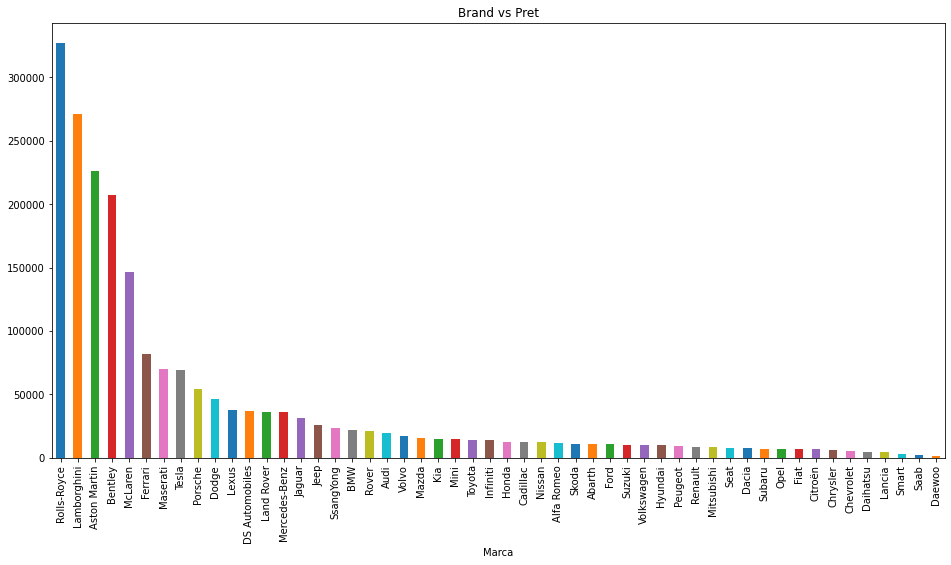

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, (1, 4))
df_brand = df.groupby(['Marca'])['price'].mean().sort_values(ascending = False)
plt1 = df_brand.plot(
    xlabel="Marca",
    kind="bar",
    color=plt.cm.tab10(np.arange(len(df['Marca'])) % plt.cm.tab10.N)
)
plt.title('Brand vs Pret')
plt.show()

### Visualizing regional prices

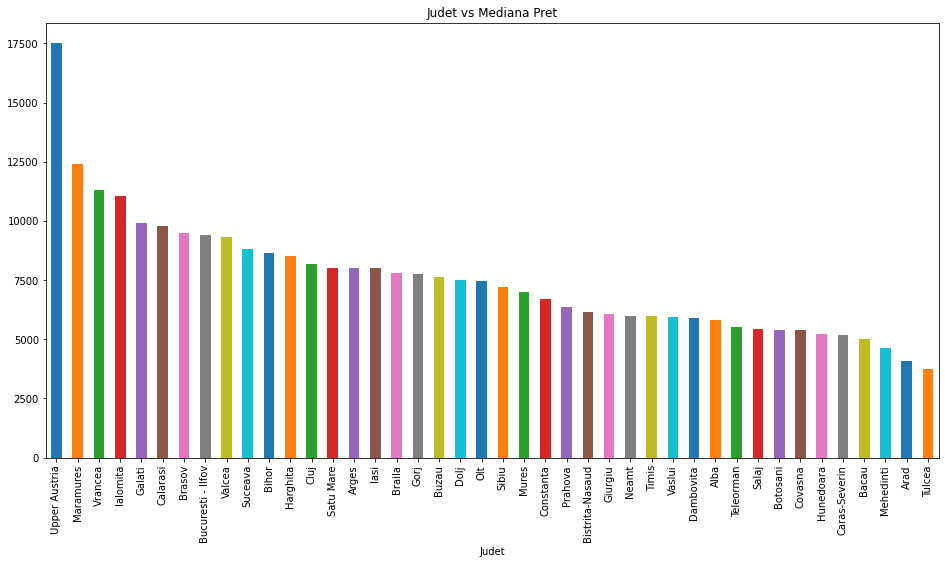

In [70]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, (1, 2))
df_cc = df.groupby(['region_name'])['price'].median().sort_values(ascending = False)
df_cc.plot(
    xlabel="Judet",
    kind="bar",
    color=plt.cm.tab10(np.arange(len(df.region_name)) % plt.cm.tab10.N)
)
plt.title('Judet vs Mediana Pret')
plt.show()

### Visualizing fuel tech prices

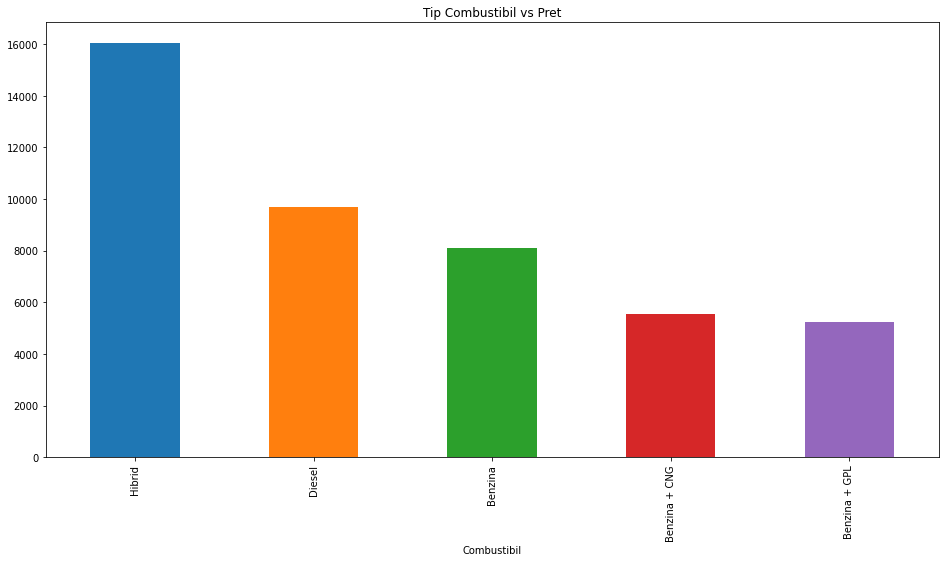

In [72]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
df_fuel = df.groupby(['Combustibil'])['price'].mean().sort_values(ascending = False)
plt1 = df_fuel.plot(
    xlabel="Combustibil",
    kind="bar", 
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.title('Tip Combustibil vs Pret')
plt.show()

### Visualizing categorical data
##### Categorical data
- brand
- model
- fuel type
- car body
- door number
- drive wheel (front, back, 4x4)
- status new / used

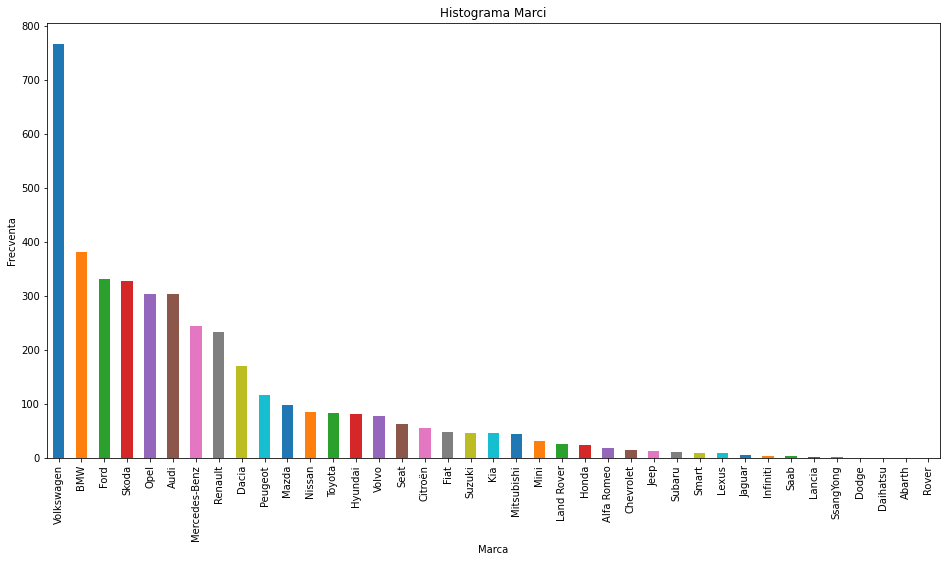

In [73]:
plt.figure(figsize=(16, 8))
plt1 = df['Marca'].value_counts().plot(
    kind='bar', 
    color=plt.cm.tab10(np.arange(len(df['Marca'])) % plt.cm.tab10.N)
)
plt.title('Histograma Marci')
plt1.set(xlabel = 'Marca', ylabel='Frecventa')

plt.show()

In [13]:
# Hist by models

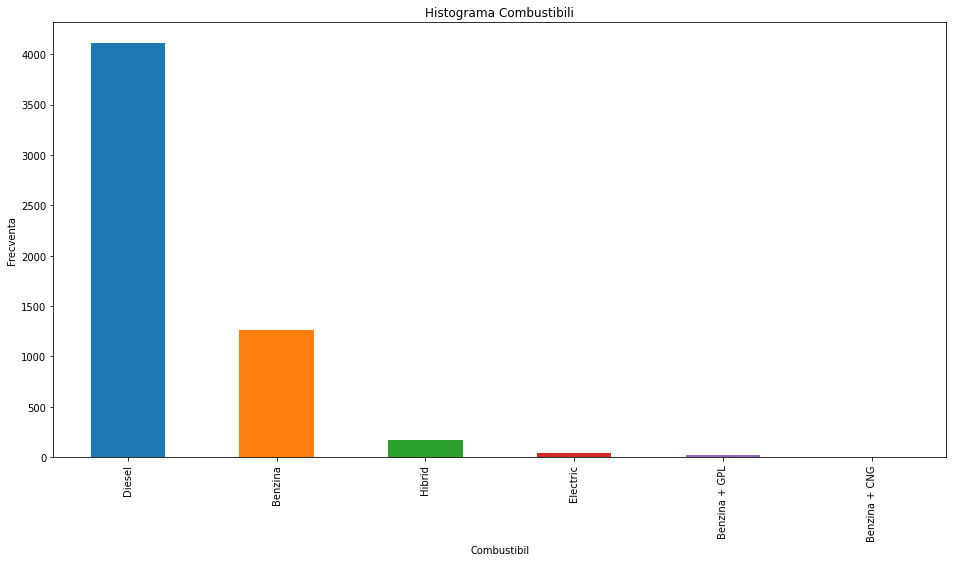

In [14]:
plt.figure(figsize=(16, 8))
plt1 = df.Combustibil.value_counts().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.title('Histograma Combustibili')
plt1.set(xlabel = 'Combustibil', ylabel='Frecventa')

plt.show()

[Text(0.5, 0, 'Caroserie'), Text(0, 0.5, 'Frecventa')]

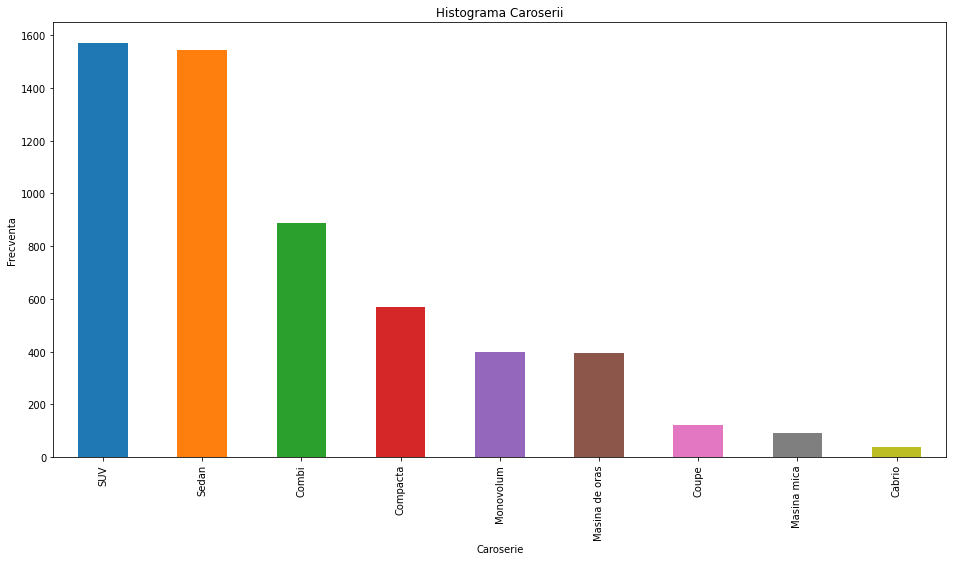

In [15]:
plt.figure(figsize=(16, 8))
plt1 = df['Caroserie'].value_counts().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df['Caroserie'])) % plt.cm.tab10.N)
)
plt.title('Histograma Caroserii')
plt1.set(xlabel = 'Caroserie', ylabel='Frecventa')

[Text(0.5, 0, 'An'), Text(0, 0.5, 'Frecventa')]

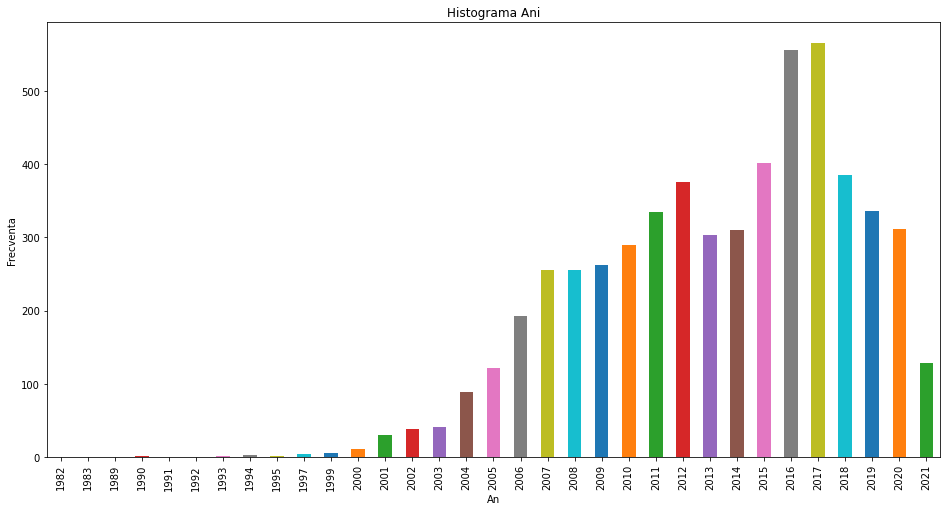

In [16]:
plt.figure(figsize=(16, 8))
plt1 = df.fabrication_year.value_counts().sort_index().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.fabrication_year)) % plt.cm.tab10.N)
)

plt.title('Histograma Ani')
plt1.set(xlabel = 'An', ylabel='Frecventa')

## Numerical data visualization

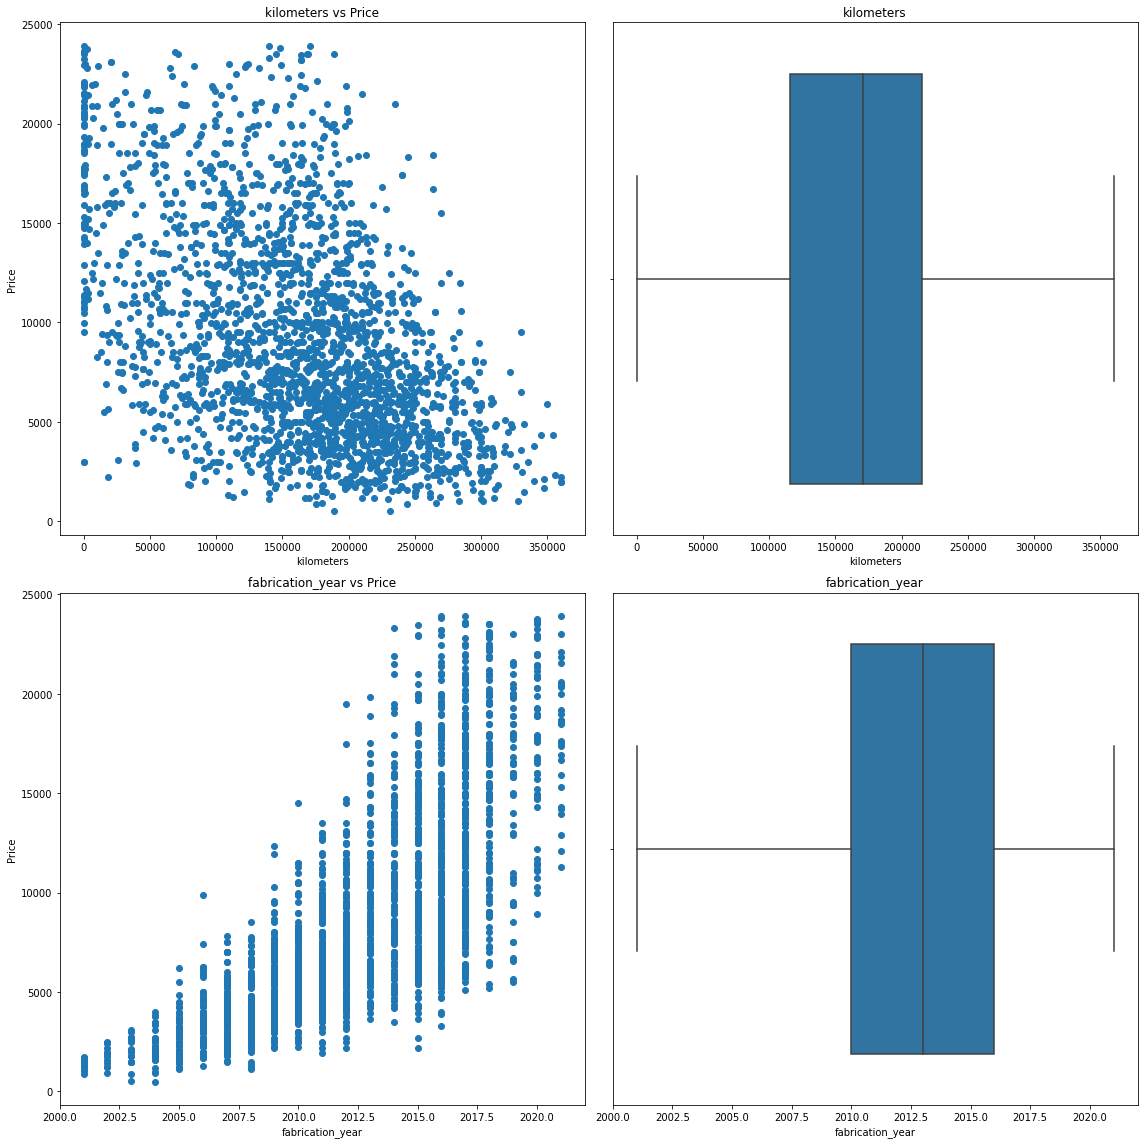

In [136]:
def remove_outliers(x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3 - Q1 # IQR is interquartile range. 
    filter = (df[x] >= Q1 - 1.5 * IQR) & (df[x] <= Q3 + 1.5 * IQR)
    return df.loc[filter]  

def scatter(x, fig):
    plt.subplot(2, 2, fig)
    plt.scatter(df[x], df['price'])
    plt.title(x + ' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

def boxplot(x, fig):
    plt.subplot(2, 2, fig)
    sea.boxplot(df[x])
    plt.title(x)
    plt.xlabel(x)
    
def distplot(x, fig):
    plt.subplot(2, 2, fig)
    sea.distplot(df[x])
    plt.title(x)
    plt.xlabel(x)
    
# Filter price ourliers
df = remove_outliers('price')

plt.figure(figsize=(16, 16))

df = remove_outliers('kilometers')
scatter('kilometers', 1)
boxplot('kilometers', 2)

df = remove_outliers('fabrication_year')
scatter('fabrication_year', 3)
boxplot('fabrication_year', 4)

plt.tight_layout()

### 

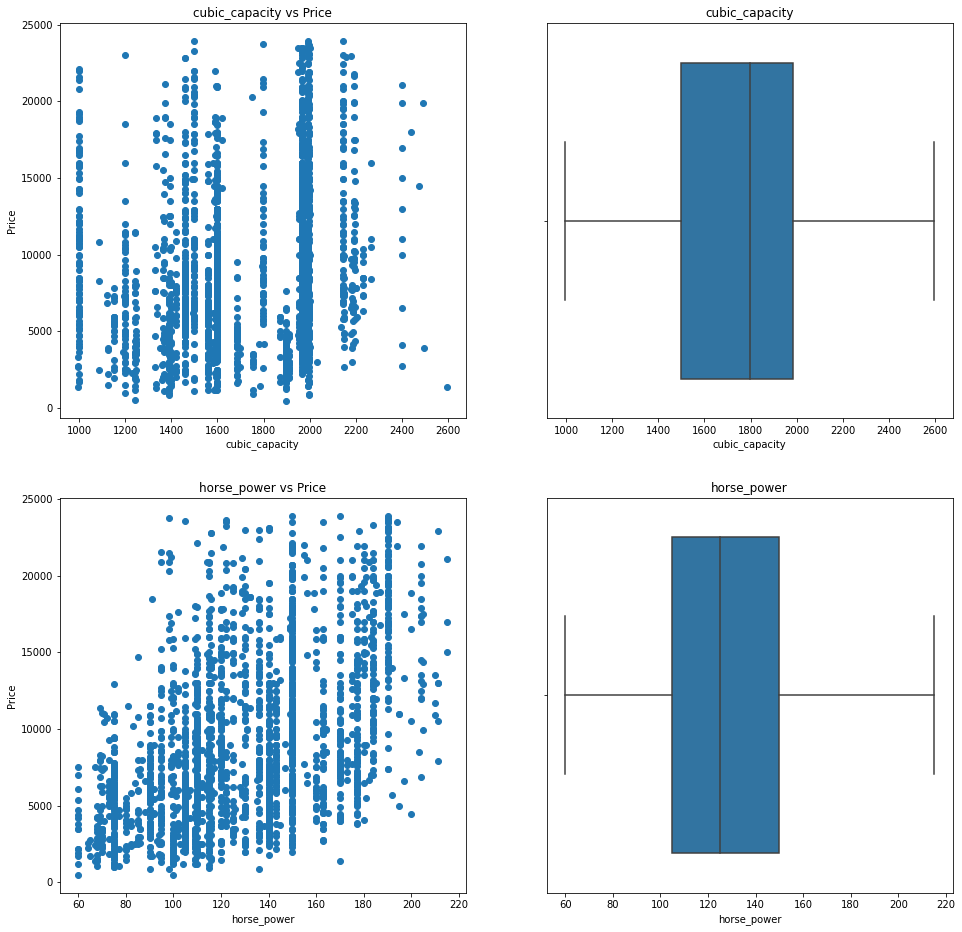

In [137]:
plt.figure(figsize=(16, 16))

df = remove_outliers('cubic_capacity')
scatter('cubic_capacity', 1)
boxplot('cubic_capacity', 2)

df = remove_outliers('horse_power')
scatter('horse_power', 3)
boxplot('horse_power', 4)

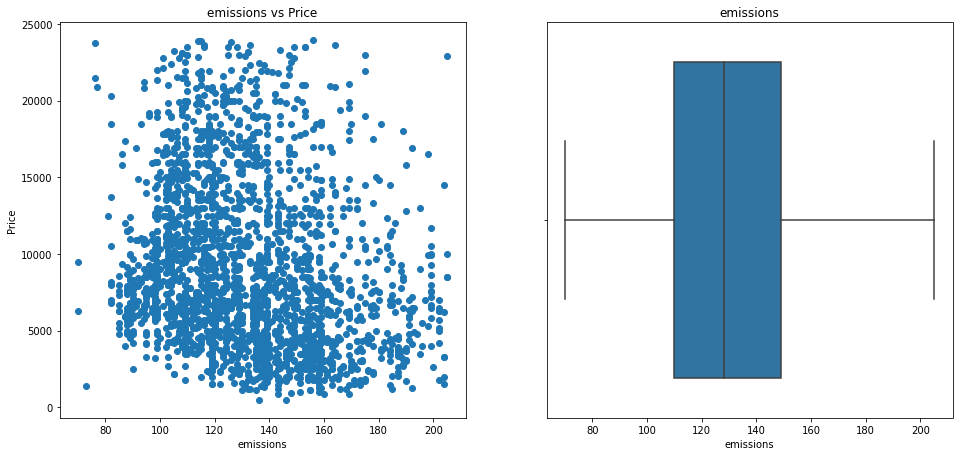

In [139]:
plt.figure(figsize=(16, 16))

df = remove_outliers('emissions')
scatter('emissions', 1)
boxplot('emissions', 2)

### Cars by prices

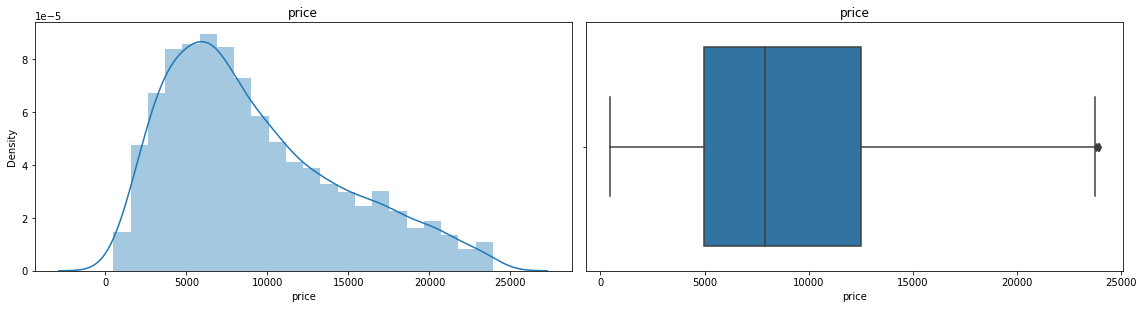

In [142]:
plt.figure(figsize=(16, 8))
distplot('price', 1)
boxplot('price', 2)
plt.tight_layout()

### Correleation coef. between fab year and km

In [143]:
np.corrcoef(df['fabrication_year'], df['kilometers'])[0, 1]

-0.6130075628718779

### Bivariate Analysis fab year and km

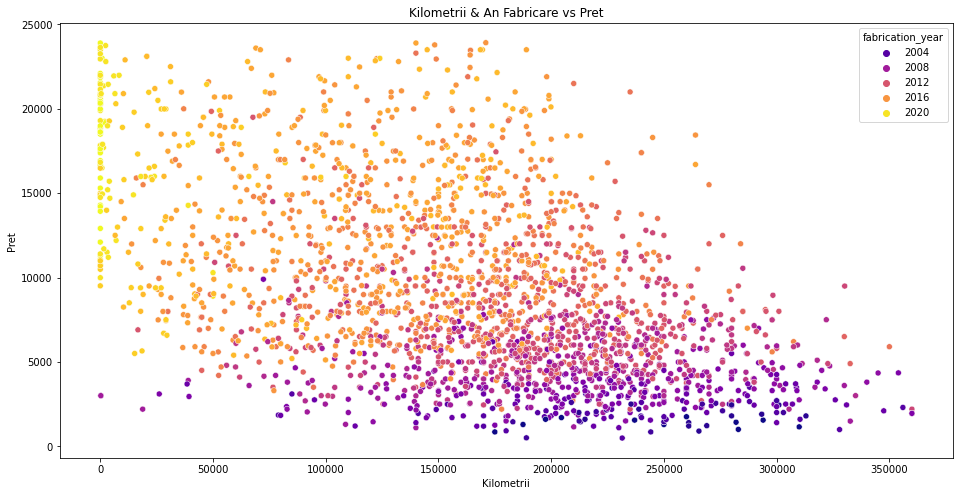

In [144]:
plt.figure(figsize=(16, 8))
plt.title('Kilometrii & An Fabricare vs Pret')
sea.scatterplot(x=df['kilometers'], y=df['price'], hue=df['fabrication_year'], palette=plt.cm.plasma)
plt.xlabel('Kilometrii')
plt.ylabel('Pret')

plt.show()

### Significant variables after visual analysis:
- price
- budget range 
- brand
- model
- fuel type / fuel technology
- body type
- kilometers (negative coeff)
- cubic capacity
- horse power
- fabrication year
- emissions

## Building a model

In [150]:
df_model = df[[
    'price', 
#     'budget_range', 
#     'brand_model',
#     'Marca', 
#     'Model', 
#     'fuel', 
#     'Caroserie', 
    'kilometers', 
#     'cubic_capacity', 
    'horse_power', 
    'fabrication_year', 
#     'emissions'
]]
df_model.head()

,price,kilometers,horse_power,fabrication_year
1,8950,298350,143.0,2011
2,9599,206000,143.0,2013
3,9500,139795,140.0,2013
5,4500,241000,92.0,2011
6,21000,235000,184.0,2014


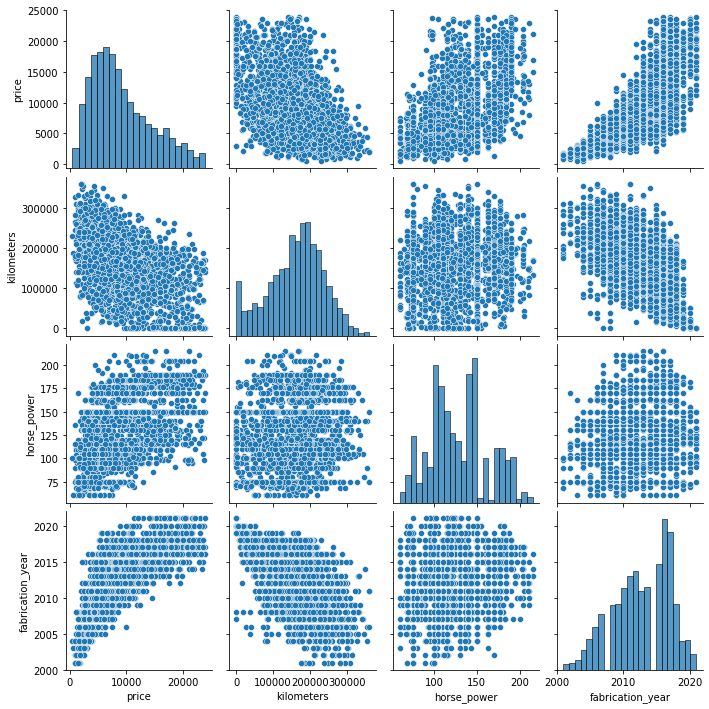

In [151]:
sea.pairplot(df_model)
plt.show()

## Dummy vars for categorical

In [152]:
# Defining the map function
def dummies(x):
    temp = pd.get_dummies(df_model[x], drop_first = True)
    df_dummies = pd.concat([df_model, temp], axis = 1)
    df_dummies.drop([x], axis = 1, inplace = True)
    return df_dummies

# df_model = dummies('budget_range')
# df_model = dummies('Marca')
# df_model = dummies('brand_model')
# df_model = dummies('fuel')
# df_model = dummies('Caroserie')
# df_model = dummies('emissions')

df_model.head()

,price,kilometers,horse_power,fabrication_year
1,8950,298350,143.0,2011
2,9599,206000,143.0,2013
3,9500,139795,140.0,2013
5,4500,241000,92.0,2011
6,21000,235000,184.0,2014


In [153]:
df_model.shape

(2472, 4)

In [168]:
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


# clean of NaN, inf, -inf
df_model = clean_dataset(df_model)
np.random.seed(0)

# split data 
df_train, df_test = train_test_split(df_model, train_size = 0.8, test_size = 0.2, random_state = 100)

In [169]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_vars = [
    'price', 
    'kilometers', 
#     'cubic_capacity', 
    'horse_power', 
    'fabrication_year', 
#     'emissions'
]
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [170]:
df_train.describe()

,price,kilometers,horse_power,fabrication_year
count,1977.000000,1977.000000,1977.000000,1977.000000
mean,0.366778,0.455332,0.446587,0.584294
std,0.226947,0.205283,0.216454,0.212751
min,0.000000,0.000000,0.000000,0.000000
25%,0.188298,0.324998,0.290323,0.450000
50%,0.312065,0.474999,0.419355,0.600000
75%,0.512441,0.597221,0.580645,0.750000
max,1.000000,1.000000,1.000000,1.000000


### Highly correlated variables to price

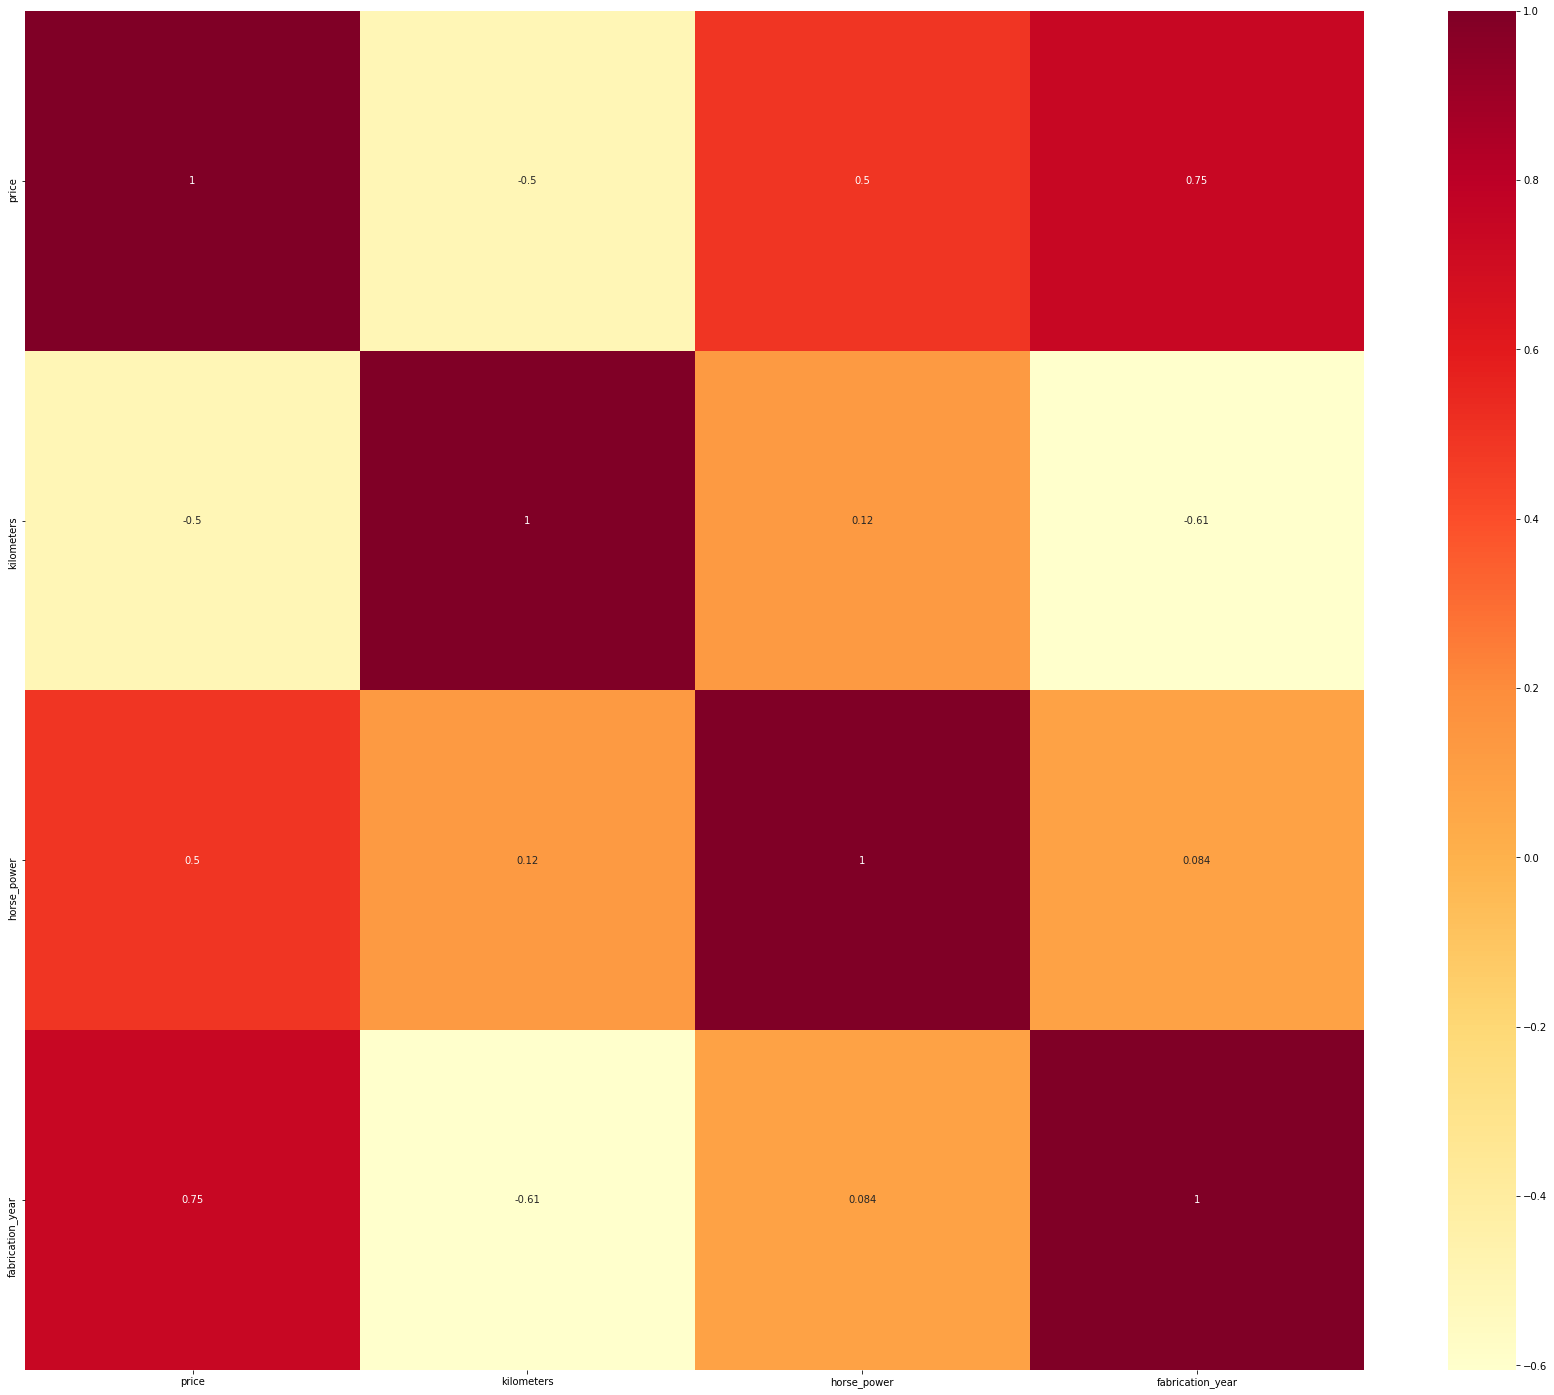

In [171]:
plt.figure(figsize = (30, 25))
sea.heatmap(df_train.corr(), annot = True, cmap="YlOrRd")
plt.show()

### Dividing into X, y

In [172]:
y_train = df_train.pop('price')
X_train = df_train

if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
    raise Exception

X_train.head()

,kilometers,horse_power,fabrication_year
3099,0.694444,0.580645,0.55
4577,0.644443,0.516129,0.65
788,0.533332,0.290323,0.55
3314,0.513610,0.064516,0.45
2453,0.747222,0.322581,0.40


### Model building

In [173]:
# Recursive feature elimination
# Pruning low correlation coef. features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10, verbose=1)
rfe = rfe.fit(X_train, y_train)

In [174]:
# Show list with supported features and ranking
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('kilometers', True, 1),
 ('horse_power', True, 1),
 ('fabrication_year', True, 1)]

In [175]:
X_train.columns[rfe.support_]

Index(['kilometers', 'horse_power', 'fabrication_year'], dtype='object')

In [176]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,kilometers,horse_power,fabrication_year
3099,0.694444,0.580645,0.55
4577,0.644443,0.516129,0.65
788,0.533332,0.290323,0.55
3314,0.513610,0.064516,0.45
2453,0.747222,0.322581,0.40


## Build model 1

In [177]:
def build_model(X, y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y, X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [178]:
X_train_new = build_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     2210.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:08:04   Log-Likelihood:                 1582.8
No. Observations:                1977   AIC:                            -3158.
Df Residuals:                    1973   BIC:                            -3135.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1138      0.014  

##### Parameters which have a p-val over 0.05 alfa, statistically insignificant, droping

In [179]:
# X_train_new = X_train_new.drop(['Medium'], axis = 1)
# X_train_new = build_model(X_train_new, y_train)

### Variance Inflation Factor Calculations

In [181]:
checkVIF(X_train)

,Features,VIF
1,horse_power,5.46
2,fabrication_year,3.91
0,kilometers,3.56


## Residual analysis of model

In [182]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train_price = lm.predict(X_train_new)

Text(0.5, 0, 'Errors')

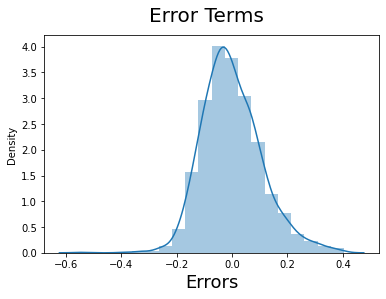

In [183]:
# Plot the histogram of the error terms
fig = plt.figure()
sea.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

Error terms seem to be approximately normally distributed, so the assumption on the linear modeling seems to be fulfilled.

In [184]:
# Scaling the test set
num_vars = [
    'price', 
            'kilometers', 
#             'cubic_capacity', 
            'horse_power', 
            'fabrication_year', 
#             'emissions'
]
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [185]:
# Dividing into X and y
y_test = df_test.copy().pop('price')
X_test = df_test

In [186]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const', axis=1)

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [187]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [188]:
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.7567334889610468

Text(0, 0.5, 'y_pred')

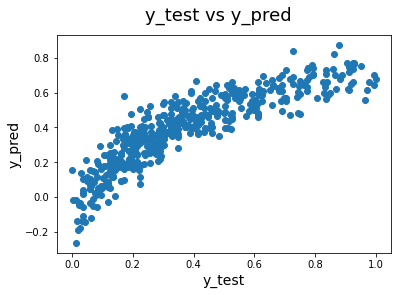

In [189]:
# EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=18)              # Plot heading 
plt.xlabel('y_test', fontsize=14)                          # X-label
plt.ylabel('y_pred', fontsize=14) 

#### Evaluation of the model using Statistics

In [190]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     2210.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:10:36   Log-Likelihood:                 1582.8
No. Observations:                1977   AIC:                            -3158.
Df Residuals:                    1973   BIC:                            -3135.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1138      0.014  

R-squred and Adjusted R-squared (extent of fit) - 0.899 and 0.896 - 90% variance explained.

F-stats and Prob(F-stats) (overall model fit) - 308.0 and 1.04e-67(approx. 0.0) - Model fir is significant and explained 90% variance is just not by chance.

p-values - p-values for all the coefficients seem to be less than the significance level of 0.05. - meaning that all the predictors are statistically significant.